In [2]:
from pathlib import Path
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from data_scripts import *

tex_fonts = {
    # Use LaTeX to write all text
    # "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
}

sns.set_theme(
    # context="talk",
    context="paper",
    # rc={"figure.figsize": (8, 6)},
    palette="bright",
    style="whitegrid",
    rc=tex_fonts,
)

CONVERGED = False
NUM_SIMS = 1


data = {
    "CPR": load_data("thermal_cpr", n_newest=NUM_SIMS),
    "Schur": load_data("thermal_schur", n_newest=NUM_SIMS),
    "Dynamic": load_data("thermal_dynamic", n_newest=NUM_SIMS),
    "Random": load_data("thermal_random", n_newest=NUM_SIMS),
}

# save_media_path = Path('/dev/null')
save_media_path = None

Loading data:
/home/firedrake/workspace/porepy_workspace/solver_selector/examples/1/performance/thermal_cpr_3.npy
Loading data:
/home/firedrake/workspace/porepy_workspace/solver_selector/examples/1/performance/thermal_schur_3.npy
Loading data:
/home/firedrake/workspace/porepy_workspace/solver_selector/examples/1/performance/thermal_dynamic_3.npy


CPR 0.2709076404571533 0.0
Schur 0.2949824333190918 0.0
Dynamic 0.21556305885314941 0.0


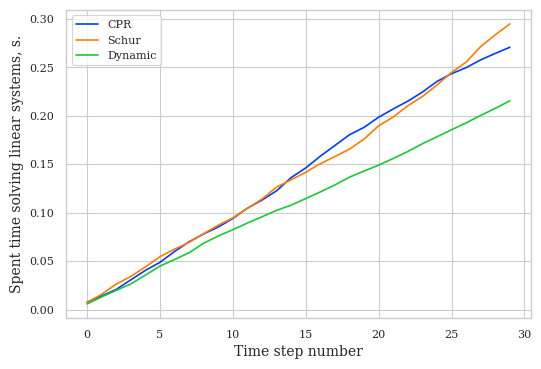

In [3]:
color_iter = -1
plt.figure(figsize=(6, 4))
for name, values in data.items():
    results = [make_solve_linear_system_time(value) for value in values]
    color_iter += 1
    make_label = True
    total = []
    for result in results:
        result = np.cumsum(result)
        total.append(result[-1])
        if make_label:
            plt.plot(result, color=f"C{color_iter}", label=name)
            make_label = False
        else:
            plt.plot(result, color=f"C{color_iter}")
    print(name, np.mean(total), np.max(total) - np.min(total))

plt.legend()
plt.xlabel("Time step number")
plt.ylabel("Spent time solving linear systems, s.")

if save_media_path is not None:
    plt.savefig(save_media_path / 'thermal_performance.pdf', bbox_inches='tight')

CPR 0.2709076404571533
Schur 0.2949824333190918
Dynamic 0.21556305885314941


Text(0, 0.5, 'Spent time solving linear systems, s.')

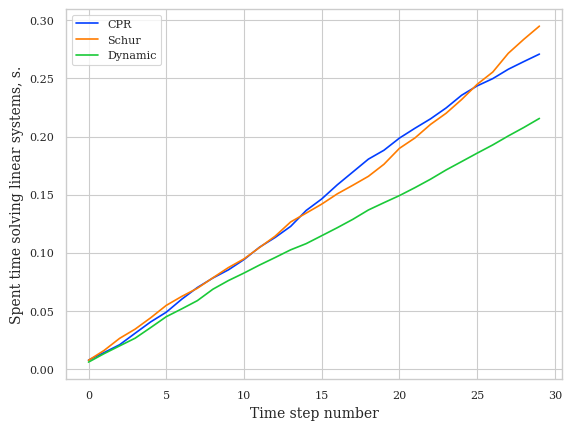

In [5]:
for name, values in data.items():
    results = [make_solve_linear_system_time(value) for value in values]
    print(name, np.mean(results, axis=0).sum())
    results = np.cumsum(results, axis=1)
    res_mean = results.mean(axis=0)
    res_max = results.max(axis=0)
    res_min = results.min(axis=0)
    plt.fill_between(np.arange(res_mean.size), res_min, res_max, alpha=0.4)
    plt.plot(res_mean, label=name)

plt.legend()
plt.xlabel("Time step number")
plt.ylabel("Spent time solving linear systems, s.")

0


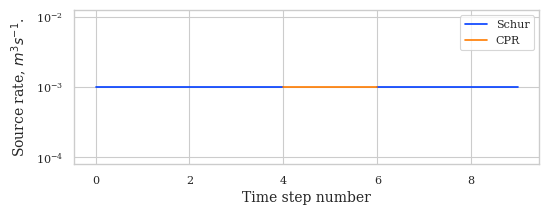

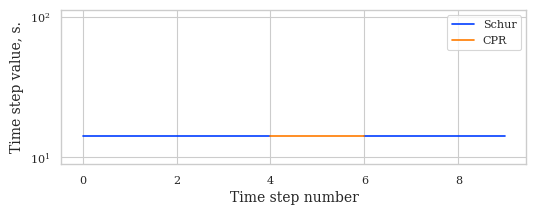

In [6]:
def color_using_schur(using_schur, values, ax=None):
    using_schur = np.array(using_schur).copy()
    using_cpr = ~using_schur
    using_schur[1:] += using_schur[:-1]
    using_schur[:-1] += using_schur[1:]

    if ax is None:
        ax = plt.gca()

    ax.plot(np.where(using_schur, values, None), label="Schur")
    ax.plot(np.where(using_cpr, values, None), label="CPR")
    ax.legend()


def make_using_schur_indices(perf: Sequence[SolverSelectionData], converged=True):
    using_schur = np.array(
        ["schur_cd" in data.config["gmres"]["preconditioner"] for data in perf]
    )
    if converged:
        return using_schur[make_converged_indices(perf)]
    return using_schur


def plot_characteristics_color_schur(perf):
    using_schur = make_using_schur_indices(perf, converged=CONVERGED)
    time_step = make_time_step(perf, converged=CONVERGED)
    inlet_rate = make_inlet_rate(perf, converged=CONVERGED)

    plt.figure(figsize=(6, 2))
    color_using_schur(using_schur, inlet_rate)
    plt.ylabel("Source rate, $m^3 s^{-1}$.")
    plt.xlabel("Time step number")
    plt.yscale("log")
    if save_media_path is not None:
        plt.savefig(save_media_path / "thermal_source.pdf", bbox_inches="tight")

    plt.figure(figsize=(6, 2))
    plt.ylabel("Time step value, s.")
    plt.xlabel("Time step number")
    color_using_schur(using_schur, time_step)
    plt.yscale("log")
    if save_media_path is not None:
        plt.savefig(save_media_path / "thermal_dt.pdf", bbox_inches="tight")


for i, perf in enumerate(data['Dynamic']):
    print(i)
    plot_characteristics_color_schur(data["Dynamic"][0])
    plt.show()